In [12]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

Manual seeding

In [13]:
torch.manual_seed(111)

In [14]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

We will need to perform conversions to our grayscale images

In [15]:
transform = transforms.Compose([
    # to tensor converts data to a pytorch tensor
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
    # to tensor makes value between 0 and 1
    # normalize makes value between -1 and 1
    # we do this by subtracting 0.5 from each value and dividing by 0.5
])

In [16]:
train_set = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)

In [17]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

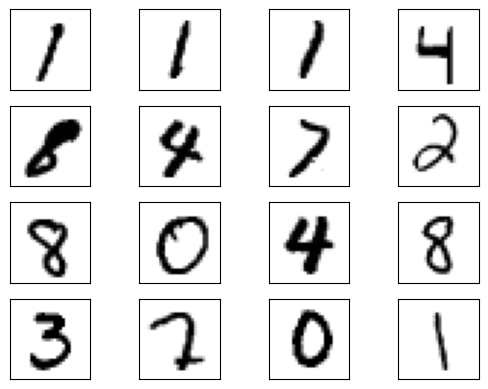

In [18]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    # cmap="gray_r" makes the image black and white
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])


In [19]:
# number of gpu's available
ngpu = 1
# input noise dimension
nz = 100
# number of generator filters
ngf = 64
#number of discriminator filters
ndf = 64


Creating a discriminator that receives a 28 x 28 pixel image

In [20]:
# https://github.com/Ksuryateja/DCGAN-MNIST-pytorch/blob/master/gan_mnist.py
# https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/acgan/acgan.py

class Discriminator(nn.Module):
    # nc: number of channels (rgb is 3 / grayscale is 1)
    # nz: input noise dimension
    # ngf: number of generator filters
    # ndf: number of 
    def __init__(self, ngpu, nc=1, ndf=64):
        self.ngpu = ngpu
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # we flatten the image to a vector of 784
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # layer 2
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # layer 3
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # layer 4
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=False),
            # our latent space vector is 1 dimensional
            # the shape of it is 32 x 1
            nn.Sigmoid(),
        )

    def forward(self, img, c):
        # the c is the label of the image
        # it is a one hot encoded vector
        # original shape of input is 32 x 1 x 28 x 28
        # x.size(0) is 32
        # With x.view, we flatten the image to a vector of 784
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [9]:
discriminator = Discriminator(ngpu).to(device=device)

In [10]:
class Generator(nn.Module):
    def __init__(self, ngpu, nc=1, nz=100, ngf=64):
        super().__init__()
        self.ngpu = ngpu
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, z, c):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

generator = Generator(ngpu).to(device=device)

Train the models

In [25]:
lr = 0.0001
num_epochs = 30
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [26]:
def label_to_onehot(labels, length=10):
    """
    :param labels: torch.Size([N, 1])
    :param length: M
    :return: torch.Size([M, M])
    """
    batch_size = labels.size(0)
    canvas = torch.zeros(batch_size, length)
    labels = labels.view(-1, 1)
    return canvas.scatter_(1, labels, 1)


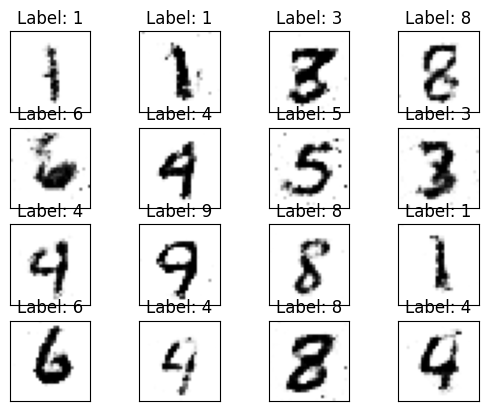

Epoch: 0 Loss D.: 0.5681378245353699
Epoch: 0 Loss G.: 0.8730719089508057


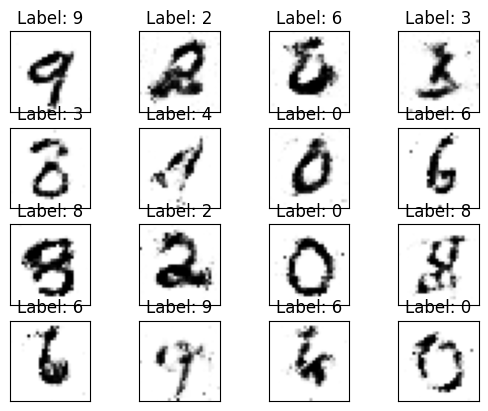

Epoch: 1 Loss D.: 0.5878589153289795
Epoch: 1 Loss G.: 1.0075578689575195


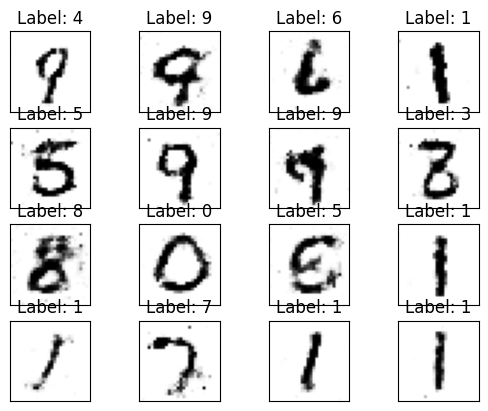

Epoch: 2 Loss D.: 0.6505588293075562
Epoch: 2 Loss G.: 0.8883874416351318


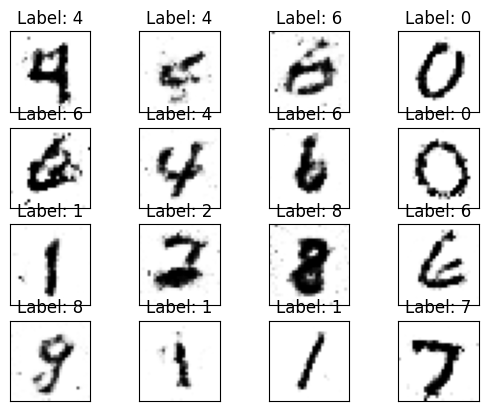

Epoch: 3 Loss D.: 0.6356676816940308
Epoch: 3 Loss G.: 0.911270022392273


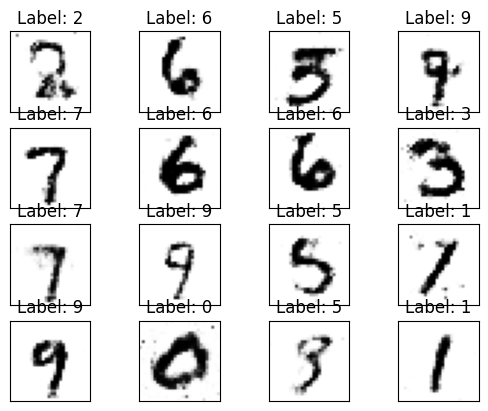

Epoch: 4 Loss D.: 0.6106362342834473
Epoch: 4 Loss G.: 0.9127799272537231


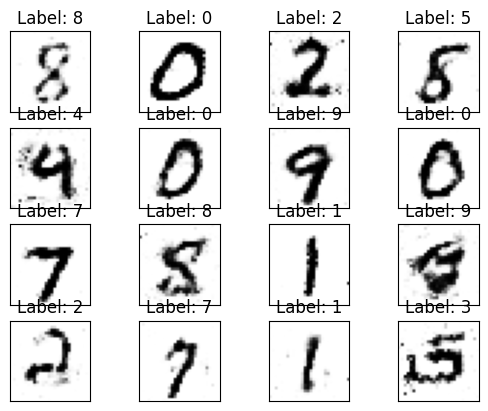

Epoch: 5 Loss D.: 0.5670132637023926
Epoch: 5 Loss G.: 0.9468419551849365


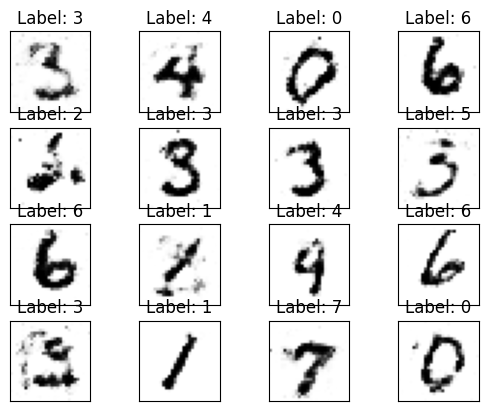

Epoch: 6 Loss D.: 0.554696261882782
Epoch: 6 Loss G.: 0.9557475447654724


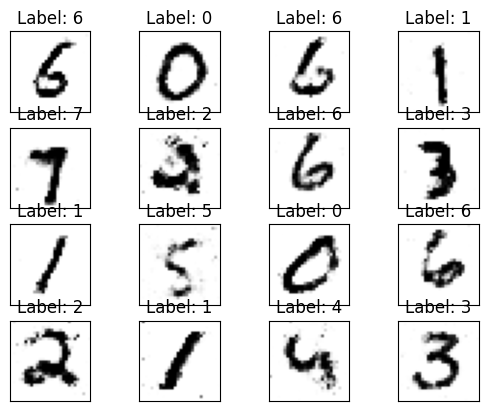

Epoch: 7 Loss D.: 0.5961247682571411
Epoch: 7 Loss G.: 1.1839494705200195


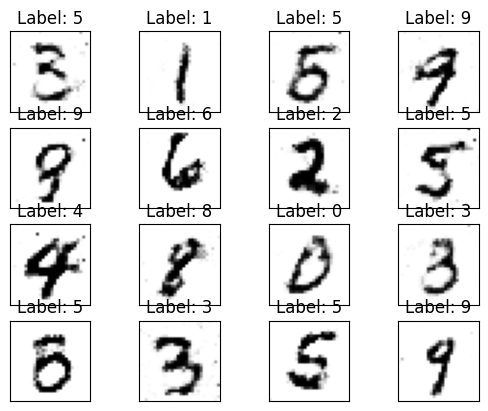

Epoch: 8 Loss D.: 0.5986145734786987
Epoch: 8 Loss G.: 0.954363226890564


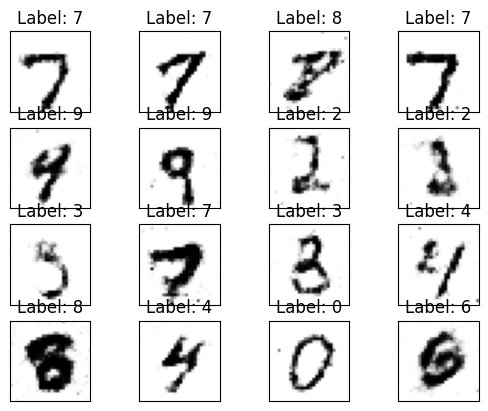

Epoch: 9 Loss D.: 0.5818063020706177
Epoch: 9 Loss G.: 0.9689416885375977


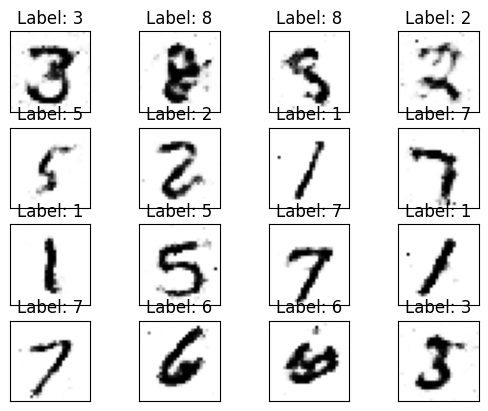

Epoch: 10 Loss D.: 0.6779912710189819
Epoch: 10 Loss G.: 1.0858036279678345


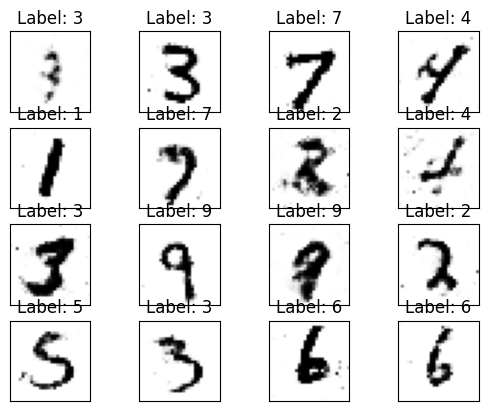

Epoch: 11 Loss D.: 0.6913998126983643
Epoch: 11 Loss G.: 0.985130786895752


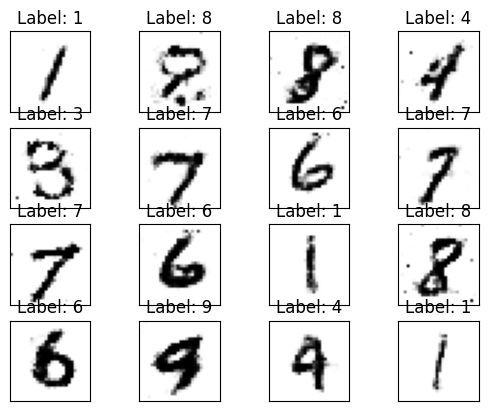

Epoch: 12 Loss D.: 0.5964037179946899
Epoch: 12 Loss G.: 0.9350435733795166


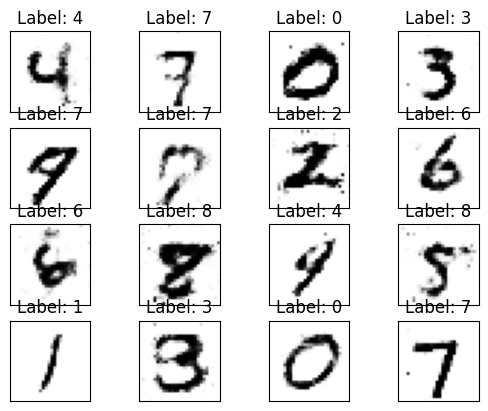

Epoch: 13 Loss D.: 0.5702300071716309
Epoch: 13 Loss G.: 1.0434117317199707


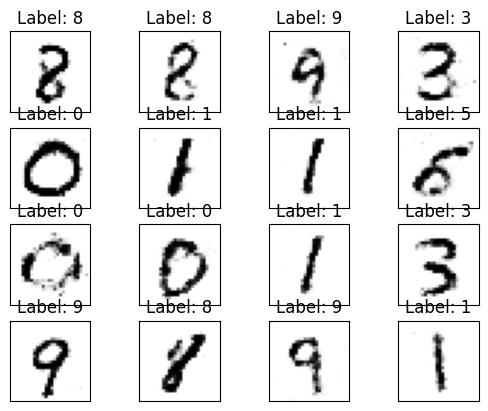

Epoch: 14 Loss D.: 0.6007938981056213
Epoch: 14 Loss G.: 0.8960574269294739


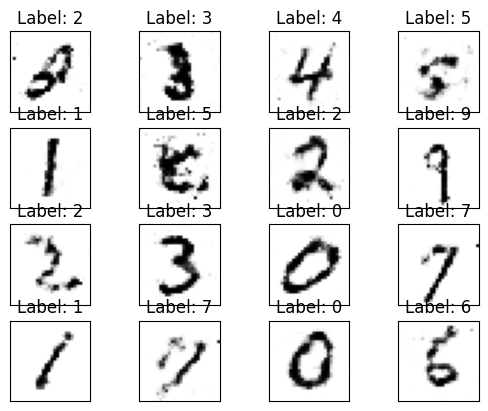

Epoch: 15 Loss D.: 0.6044825315475464
Epoch: 15 Loss G.: 0.8077883720397949


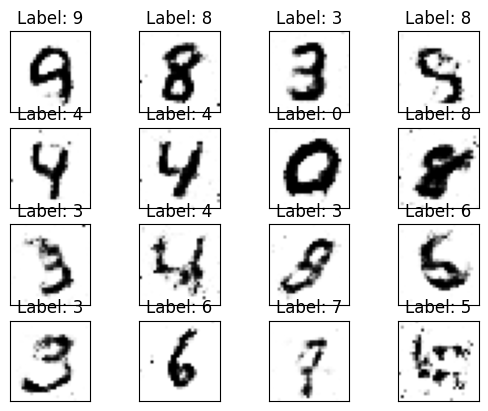

Epoch: 16 Loss D.: 0.6754285097122192
Epoch: 16 Loss G.: 0.9616546034812927


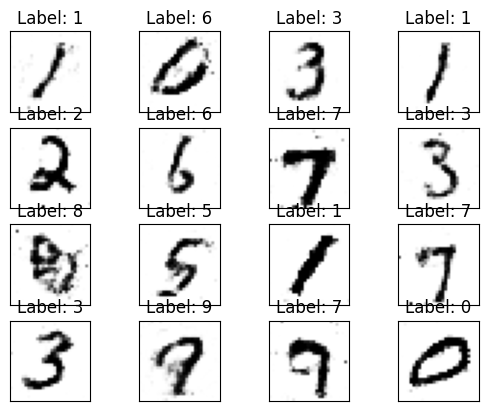

Epoch: 17 Loss D.: 0.6459875106811523
Epoch: 17 Loss G.: 0.7850192785263062


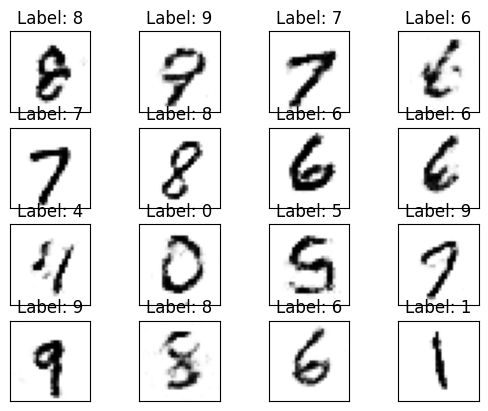

Epoch: 18 Loss D.: 0.6551533937454224
Epoch: 18 Loss G.: 0.8660849928855896


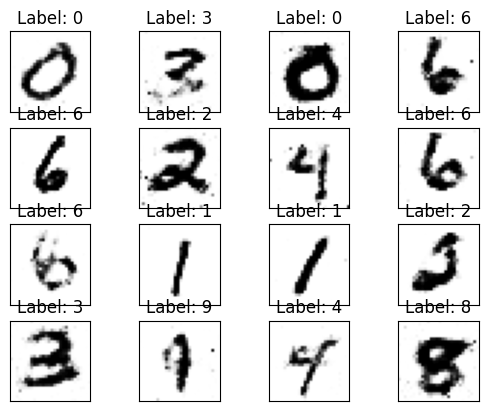

Epoch: 19 Loss D.: 0.6058628559112549
Epoch: 19 Loss G.: 0.8889636993408203


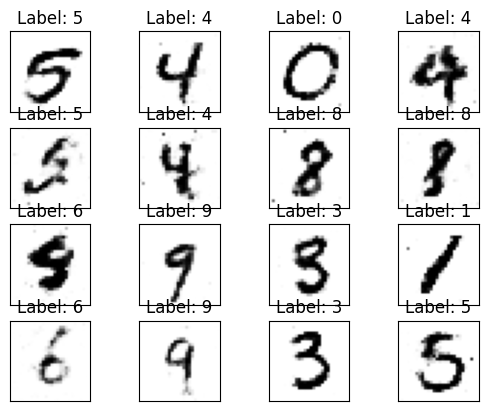

Epoch: 20 Loss D.: 0.6201399564743042
Epoch: 20 Loss G.: 0.9579389095306396


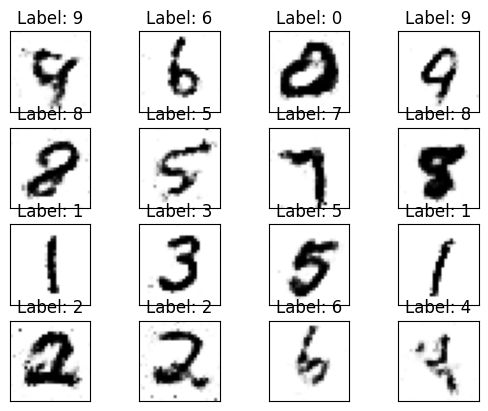

Epoch: 21 Loss D.: 0.7018178105354309
Epoch: 21 Loss G.: 0.7611027956008911


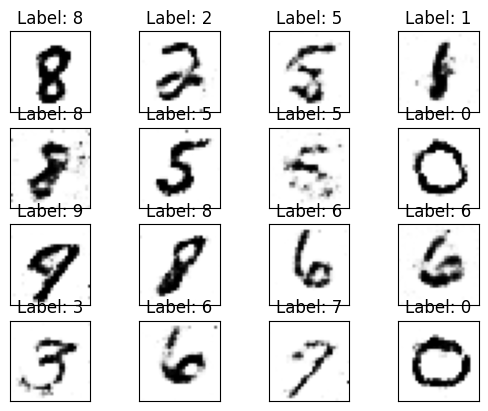

Epoch: 22 Loss D.: 0.6534289121627808
Epoch: 22 Loss G.: 0.7311142683029175


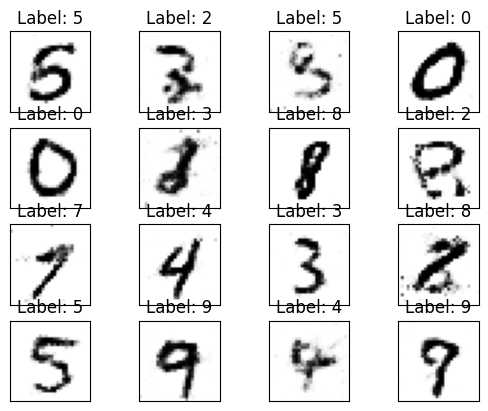

Epoch: 23 Loss D.: 0.6249914169311523
Epoch: 23 Loss G.: 1.0833626985549927


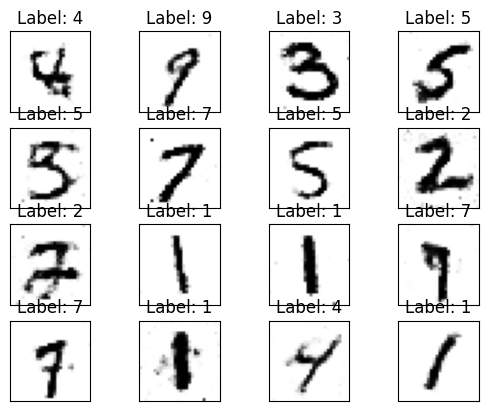

Epoch: 24 Loss D.: 0.5537006855010986
Epoch: 24 Loss G.: 0.8649411201477051


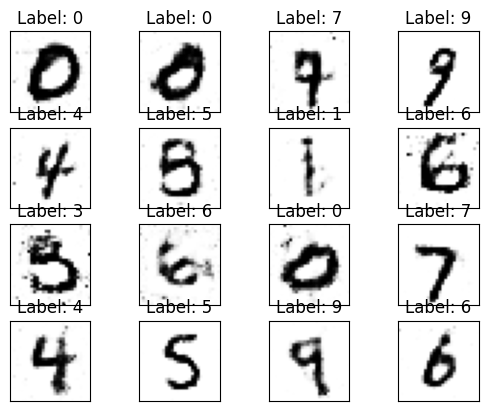

Epoch: 25 Loss D.: 0.6800835132598877
Epoch: 25 Loss G.: 0.702212929725647


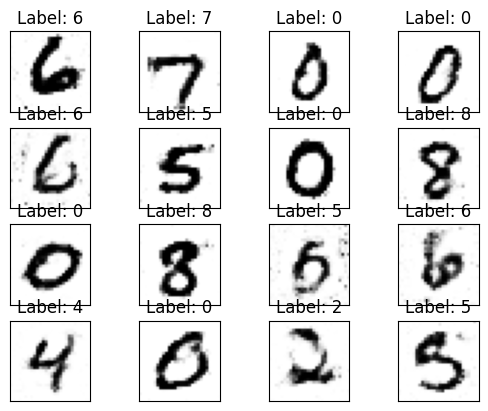

Epoch: 26 Loss D.: 0.6756444573402405
Epoch: 26 Loss G.: 0.6675736308097839


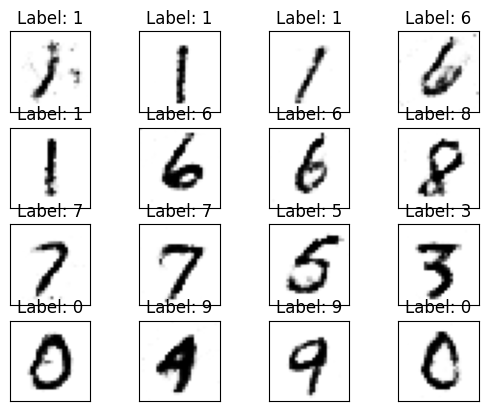

Epoch: 27 Loss D.: 0.6525412201881409
Epoch: 27 Loss G.: 1.0839428901672363


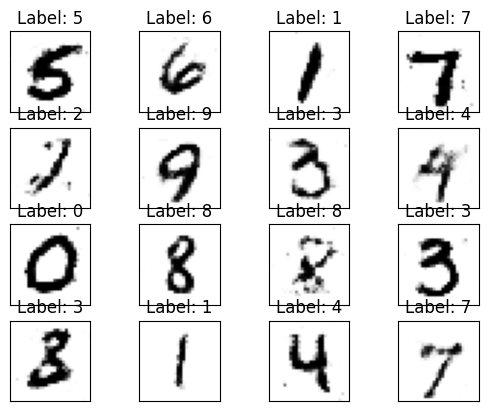

Epoch: 28 Loss D.: 0.6369203329086304
Epoch: 28 Loss G.: 0.9989186525344849


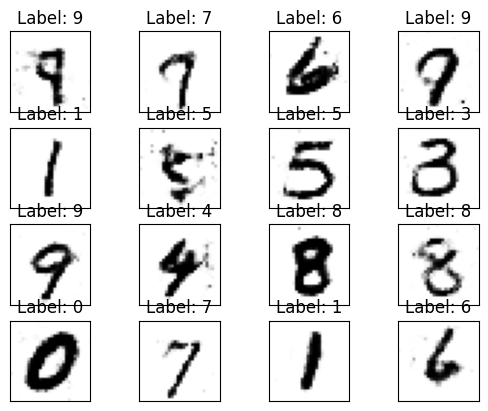

Epoch: 29 Loss D.: 0.7036852836608887
Epoch: 29 Loss G.: 0.7926040887832642


In [27]:
latent_space_samples_test = torch.randn(batch_size, 100).to(device=device)


for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        onehot = label_to_onehot(mnist_labels).to(device=device)
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples, onehot)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )
        onehot_two = torch.cat((onehot, onehot))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples, onehot_two)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples, onehot)
        output_discriminator_generated = discriminator(generated_samples, onehot)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            # Visualize the generated digits from the latent space
            latent_space_samples = torch.randn(batch_size, 100).to(device=device)
            generated_samples = generator(latent_space_samples, onehot)
            generated_samples = generated_samples.cpu().detach()
            generated_samples = generated_samples.view(-1, 28, 28)
            for i in range(16):
                ax = plt.subplot(4, 4, i + 1)
                ax.set_title(f"Label: {mnist_labels[i].item()}")
                plt.imshow(generated_samples[i], cmap="gray_r")
                plt.xticks([])
                plt.yticks([])
            plt.show()
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

In [31]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")

In [32]:
random_label = torch.randint(0, 10, (batch_size,)).long()
print(random_label)
onehot_random = label_to_onehot(random_label).to(device=device)

latent_space_samples_test = torch.randn(batch_size, 100).to(device=device)
generated_samples_test = generator(latent_space_samples_test, onehot_random)


tensor([7, 0, 3, 4, 8, 5, 5, 7, 7, 2, 7, 8, 1, 5, 6, 7, 8, 7, 5, 6, 5, 1, 1, 4,
        7, 5, 8, 3, 2, 2, 7, 2])


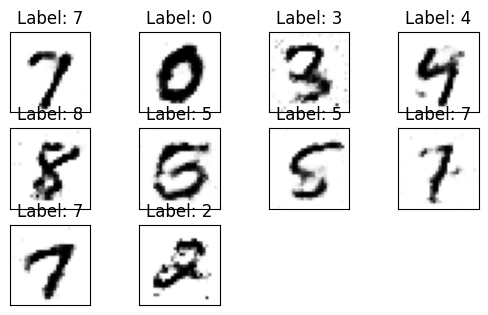

In [33]:
generated_samples_test = generated_samples_test.cpu().detach()
for i in range(10):
    ax = plt.subplot(4, 4, i + 1)
    ax.set_title(f"Label: {random_label[i]}")
    plt.imshow(generated_samples_test[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
    